We will use the make_classification() scikit-learn function to define a synthetic binary (2-class) classification task with 100 input features (columns) and 1,000 examples (rows). Importantly, we will define the problem in such a way that most of the input variables are redundant (90 of the 100 or 90 percent), allowing the autoencoder later to learn a useful compressed representation.

In [1]:
# synthetic classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


In [2]:
# split into train test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

We will define the encoder to have two hidden layers, the first with two times the number of inputs (e.g. 200) and the second with the same number of inputs (100), followed by the bottleneck layer with the same number of inputs as the dataset (100 uncompressed) or reduced number of nodes representing filtered bottleneck(50). To ensure the model learns well, we will use batch normalization and leaky ReLU activation.

In [3]:
# define encoder
from keras.layers import Input, Dense, LeakyReLU 
from keras.layers.normalization import BatchNormalization

n_inputs = 100
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
#n_bottleneck = n_inputs # no compression of bottleneck
n_bottleneck = round(float(n_inputs) / 2.0) # reduced nodes to 50
bottleneck = Dense(n_bottleneck)(e)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-09-21 09:00:30.222452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-21 09:00:30.222545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The decoder will be defined with a similar structure, although in reverse. It will have two hidden layers, the first with the number of inputs in the dataset (e.g. 100) and the second with double the number of inputs (e.g. 200). The output layer will have the same number of nodes as there are columns in the input data and will use a linear activation function to output numeric values.

In [4]:
# define decoder, level 1
from keras.models import Model, load_model
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

The model will be fit using the efficient Adam version of stochastic gradient descent and minimizes the mean squared error, given that reconstruction is a type of multi-output regression problem.

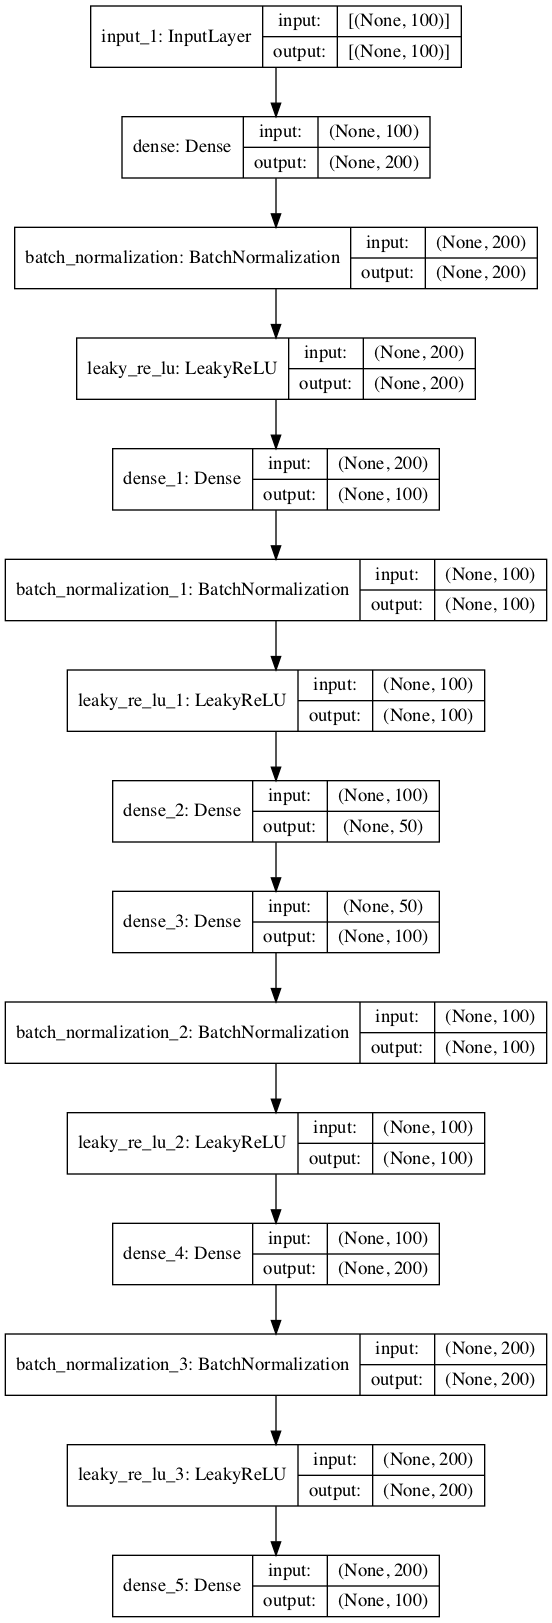

In [5]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
from keras.utils.vis_utils import plot_model
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

Next, we can train the model to reproduce the input and keep track of the performance of the model on the hold-out test set.

In [6]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test, X_test))

2021-09-21 09:00:31.004521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-21 09:00:31.004702: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2021-09-21 09:00:38.336087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 - 9s - loss: 0.2336 - val_loss: 0.1795


2021-09-21 09:00:39.501788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/200
42/42 - 1s - loss: 0.0363 - val_loss: 0.1060
Epoch 3/200
42/42 - 1s - loss: 0.0230 - val_loss: 0.0574
Epoch 4/200
42/42 - 1s - loss: 0.0183 - val_loss: 0.0331
Epoch 5/200
42/42 - 1s - loss: 0.0157 - val_loss: 0.0210
Epoch 6/200
42/42 - 1s - loss: 0.0139 - val_loss: 0.0124
Epoch 7/200
42/42 - 1s - loss: 0.0121 - val_loss: 0.0103
Epoch 8/200
42/42 - 1s - loss: 0.0121 - val_loss: 0.0086
Epoch 9/200
42/42 - 1s - loss: 0.0115 - val_loss: 0.0081
Epoch 10/200
42/42 - 1s - loss: 0.0107 - val_loss: 0.0073
Epoch 11/200
42/42 - 1s - loss: 0.0108 - val_loss: 0.0063
Epoch 12/200
42/42 - 1s - loss: 0.0092 - val_loss: 0.0060
Epoch 13/200
42/42 - 1s - loss: 0.0090 - val_loss: 0.0053
Epoch 14/200
42/42 - 1s - loss: 0.0092 - val_loss: 0.0058
Epoch 15/200
42/42 - 1s - loss: 0.0084 - val_loss: 0.0060
Epoch 16/200
42/42 - 1s - loss: 0.0077 - val_loss: 0.0045
Epoch 17/200
42/42 - 1s - loss: 0.0083 - val_loss: 0.0047
Epoch 18/200
42/42 - 1s - loss: 0.0079 - val_loss: 0.0047
Epoch 19/200
42/42 - 1

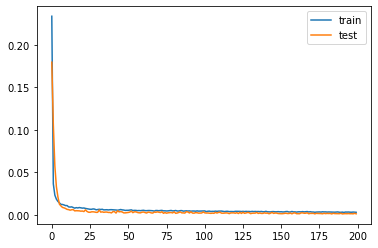

In [7]:
# plot loss
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Save the encoder for use later. As part of saving the encoder, we will also plot the encoder model to get a feeling for the shape of the output of the bottleneck layer, e.g. a 50 compressed element vector.

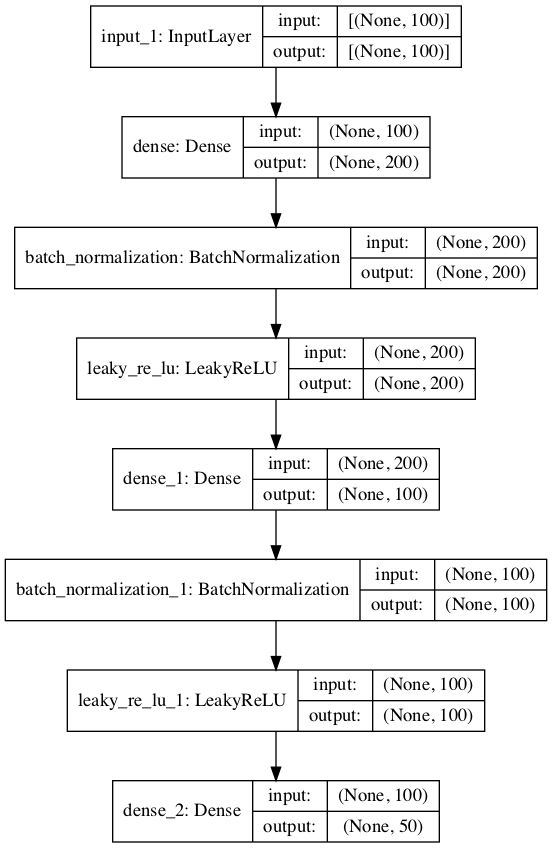

In [9]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')
plot_model(encoder, 'encoder_compress.png', show_shapes=True)

In this section, we will use the trained encoder from the autoencoder to compress input data and train a different predictive model. First, let’s establish a baseline in performance on this problem. This is important as if the performance of a model is not improved by the compressed encoding, then the compressed encoding does not add value to the project and should not be used. We can train a logistic regression model on the training dataset directly and evaluate the performance of the model on the holdout test set.

In [10]:
# baseline in performance with logistic regression model
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define model
model = LogisticRegression()
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8939393939393939


We would hope and expect that a logistic regression model fit on an encoded version of the input to achieve better accuracy for the encoding to be considered useful. We can update the example to first encode the data using the encoder model trained in the previous section.

First, we can load the trained encoder model from the file. We can then use the encoder to transform the raw input data (e.g. 100 columns) into bottleneck vectors (e.g. 50 element vectors). This process can be applied to the train and test datasets.

In [11]:
# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

2021-09-21 09:07:38.922652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [12]:
#We can then use this encoded data to train and evaluate the logistic regression model, as before.
# define the model
model = LogisticRegression(max_iter=2000)
# fit the model on the training set
model.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.9303030303030303
